## As we discussed in the Introduction to Python tutorial, it can get pretty repetitive to run long blocks of code and then try to find single line errors. In order to clean up our code and reduce places errors can occur, let's begin using Functions.

In [89]:
# First import modules and previous Functions we'll need:

# These are all the modules and definitions you will need in this notebook
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import pylab
from pylab import *
import matplotlib.gridspec as gridspec
import time
import batman
from astropy.stats import BoxLeastSquares
from transitleastsquares import period_grid

#custom binning function
def Bin_func(time,flux,error,binsize):
    good = np.where(np.isfinite(time))
    timefit = time[good]
    fluxfit = flux[good]
    errfit  = error[good]
    timemax = np.max(timefit)
    timemin = np.min(timefit)
    npoints = len(timefit)
    nbins   = int(math.ceil((timemax - timemin)/binsize)) #binsize in days
    bintime = np.full((nbins,), np.nan)
    binflux = np.full((nbins,), np.nan)
    binerr  = np.full((nbins,), np.nan)
    for i in range(0,nbins-1):
        tobin = [np.where( (timefit >= (timemin + i*binsize)) & (timefit < (timemin + (i+1)*binsize)) )]
        if tobin[0] != -1:
    #     inverse variance weighted means
            binflux[i] = ((fluxfit[tobin]/(errfit[tobin]**2.0)).sum()) / ((1.0/errfit[tobin]**2.0).sum())
            bintime[i] = ((timefit[tobin]/(errfit[tobin]**2.0)).sum()) / ((1.0/errfit[tobin]**2.0).sum())
            binerr[i]  = 1.0 / (np.sqrt( (1.0/errfit[tobin]**2.0)).sum() )
    
    good2   = np.where(np.isfinite(bintime))
    bintime = bintime[good2]
    binflux = binflux[good2]
    binerr  = binerr[good2]
    
    return bintime, binflux, binerr

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) #these are annoying.

from transitleastsquares import transitleastsquares
from transitleastsquares import catalog_info
from transitleastsquares import transit_mask


# These are used to employ your computers operating system (os) to
# search through your directories for specific files.
import glob, os
from os import listdir
from os.path import isfile, join
import fnmatch
from scipy.signal import savgol_filter


In [90]:
# Let's take our smoothing and outlier rejection procedure and turn it into a Function:

def ChauventsCriteron(x, y, z, mean=None, stdv=None):
    from scipy.special import erfc
    if mean is None:
        mean = y.mean()           # Mean of incoming array y
    if stdv is None:
        stdv = y.std()            # Its standard deviation
    N = len(y)                   # Lenght of incoming arrays
    criterion = 1.0/(2*N)        # Chauvenet's criterion
    d = abs(y-mean)/stdv         # Distance of a value to mean in stdv's
    d /= 2.0**0.5                # The left and right tail threshold values
    prob = erfc(d)               # Area normal dist.    
    filter = prob >= criterion   # The 'accept' filter array with booleans
    
    xf = x[filter]; yf = y[filter]; zf=z[filter]
#     print ("criterion: ", criterion)
#     print ("3*std:", std(y))
#     return filter                # Use boolean array outside this function
    return xf,yf,zf
# For some light curves, where there are flare events, we may need to 
# turn this off. (Will add in future versions)

def SmoothAndRemove(time,flux,flux_error,iterations):
    
    cad = time[1]-time[0]
    #now let's define a window size to smooth our data with:

    window_size = int(5.0/cad) #number of data points in 5 hours
    if (window_size % 2) == 0: #must be odd. If not, there will be an error
        window_size = window_size+1

    
    # lets smooth for a total of 10 times. Experiment with more or less iterations:
    
    o = np.ones(len(flux), dtype=bool)
    for i in range(10):  #Note: You can place a for-loop inside a for-loop!
        y_prime = np.interp(time, time[o], flux[o])
        smooth = savgol_filter(y_prime, window_size, polyorder=3)
        resid = flux - smooth +1 #add the one to have it centered on 1.0 instead of 0.0
        sigma = np.sqrt(np.mean(resid**2)) #root mean square (RMS for short)
        o0 = np.abs(resid) < 3*sigma #this is shorthand for: -3*sigma < resid < 3*sigma
        if o.sum() == o0.sum():
            o = o0
            break
        o = o0

    # Only discard positive outliers
    o = resid < 3.0*sigma

    #removing outliers with Chauvenet's criterion after smoothing
    newtime,newflux,newflux_error = ChauventsCriteron(time,resid,flux_error)
    
    return newtime,newflux,newflux_error,window_size

In [91]:
# Next, let's write a function for our BLS searches and plotting commands:
def BLS(time,flux,flux_error,ID,minP,minDur,maxDur,window_size,SDE_threshold):
    
    LCduration = time[-1]-time[0] #duration of light curve (last minus first data point)
    maxP=LCduration
    
    qld, R_star, R_star_min, R_star_max, M_star, M_star_min, M_star_max = catalog_info(TIC_ID=int(ID))   
    #^^^ grabbing stellar information from MAST catalogs
    
    if np.isfinite(R_star)==True or np.isfinite(M_star)==True: #checks to see if stellar information is unknown in MAST catalogs
    
        #creating list of orbital periods to model with
        periods = period_grid(R_star=R_star, M_star=M_star, time_span=LCduration, period_min=minP, period_max=maxP)#,oversampling_factor=10)

        durations = np.linspace(minDur,maxDur,25)

        #start BLS search
        bls = BoxLeastSquares(time, flux) #just for specific target
        bls_power = bls.power(periods, durations)

        bls_SDE = (bls_power.power - np.mean(bls_power.power))/np.std(bls_power.power)
        


        index = np.argmax(bls_power.power) #finds the index corresponding to the strongest peak in BLS power spectrum
        BLS_periods=bls_power.period[index]
        BLS_t0s=bls_power.transit_time[index]
        BLS_depths=bls_power.depth[index]
        dur = minDur #0.5

        #creating the best fit box model to our data
        bls_model=bls.model(time,bls_power.period[index], bls_power.duration[index], bls_power.transit_time[index])



        #for functions, it is useful to have some saved outputs. These are ones I think may be useful to keep track of.
        return bls, bls_power, bls_SDE, BLS_periods, BLS_t0s, BLS_depths, bls_model



In [92]:
#note bls_period = bls_power.period 
def PlotBLSResults(bls_period, bls_SDE,BLS_periods,ID,Sector,Camera,CCD,window_size, time,flux,flux_error, bls_model, BLS_t0s):
    fs=10
    fig = plt.figure(figsize=(10,6))
    gs1 = gridspec.GridSpec(3, 3)
    gs1.update(left=0.65, right=1.25, wspace=0.5,hspace=0.5)

    ax1 = fig.add_subplot(gs1[:-1, :])
    ax2 = fig.add_subplot(gs1[-1, :-1])
    ax3 = fig.add_subplot(gs1[-1, -1])

    ax1.plot(np.log10(bls_period), bls_SDE, "b")
    ax1.axvline(np.log10(BLS_periods), color="red", lw=6, alpha=0.5) #this is our strongest peak
    ax1.annotate("period = {0:.4f} days".format(BLS_periods),(0, 1), xycoords="axes fraction",
                            xytext=(50, -5), textcoords="offset points",va="top", ha="left", fontsize=12)
    ax1.set_ylabel("SDE",fontsize=fs)
    ax1.set_xlim(np.log10(np.min(bls_period))-0.1, np.log10(np.max(bls_period)+0.1))
    # plt.ylim(bls_SDE.min()-0.25, bls_SDE.max()+0.25)
    ax1.set_xlabel("log(Period ( days))",fontsize=fs)
    ax1.set_title(("TIC "+ID+" "+Sector+" Camera "+ Camera+" CCD "+ CCD + "\n Data with Savitsky-Golay filter: window = "+str(window_size)+" data points"))


    ax2.plot(time,flux,color='grey',marker=".",linestyle='none')
    ax2.plot(time,bls_model,'b.')
    ax2.set_xlabel("Time (Julian Date)")
    ax2.set_ylabel("Normalized Relative Flux")

    # Plot the folded transit
    p = BLS_periods
    x_fold = (time - BLS_t0s + 0.5*p) % p - 0.5*p

    #Bin the data
    binsize= 30.0/(60.0*24.0) 
    bint,binf,binfe = Bin_func(x_fold, flux,flux_error,binsize)

    ax3.plot(24*x_fold,flux,color='grey',marker=".",linestyle='none')#,label='smoothed subtracted data')
    ax3.plot(24*bint,binf,'ro')#,label='binned data, 30 min bins'
    ax3.plot(24*x_fold,bls_model,'b.')#,label='BLS model'
    ax3.set_xlabel(" Phase (hours)")
    #         ax3.legend(loc='best')
    ax3.set_xlim(-0.3*24,0.3*24) #+/- 0.2 hours
    fig.tight_layout()
    plt.savefig(figpath+"TIC_"+ID+"_"+Sector+"_Camera_"+Camera+"_CCD_"+CCD+"_BLS.png")
    plt.show()

In [93]:
# And let's do the same for TLS
def TLS(time,flux,flux_error,minP,window_size):
    LCduration = time[-1]-time[0] #duration of light curve (last minus first data point)
    maxP=LCduration
    
    tls = transitleastsquares(time,flux)
    tls_power = tls.power(period_min=minP,period_max=maxP,show_progress_bar=False,n_transits_min=3)#,duration_grid_step=2)

    #TLS results
    TLS_periods=tls_power.period
    TLS_t0s=tls_power.T0
    TLS_depths=tls_power.depth
    TLS_SDE=tls_power.power

    #TLS results
#     phase_model = tls_power.model_folded_phase
    TLS_model_time = tls_power.model_lightcurve_time 
    TLS_model = tls_power.model_lightcurve_model #results.model_folded_model <--- old
#     phase = tls_power.folded_phase
#     folded_y = tls_power.folded_y
    
    
    return tls, tls_power, TLS_SDE, TLS_periods, TLS_depths, TLS_t0s,TLS_model_time,TLS_model

In [94]:
# note tls_period = tls_power.periods
def PlotTLSResults(time, flux, flux_error, TLS_periods,TLS_t0s,tls_period,TLS_SDE, ID, Sector, Camera, CCD, window_size,TLS_model_time,TLS_model):
    p = TLS_periods
    x_fold = (time - TLS_t0s + 0.5*p) % p - 0.5*p
    pf_model = (TLS_model_time - TLS_t0s + 0.5*p) % p - 0.5*p

    fs=10
    fig = plt.figure(figsize=(10,6))
    gs1 = gridspec.GridSpec(3, 3)
    gs1.update(left=0.65, right=1.25, wspace=0.5,hspace=0.5)

    ax1 = fig.add_subplot(gs1[:-1, :])
    ax2 = fig.add_subplot(gs1[-1, :-1])
    ax3 = fig.add_subplot(gs1[-1, -1])

    ax1.plot(np.log10(tls_period), TLS_SDE, "b")
    ax1.axvline(np.log10(TLS_periods), color="red", lw=6, alpha=0.5) #this is our strongest peak
    ax1.annotate("period = {0:.4f} days".format(TLS_periods),(0, 1), xycoords="axes fraction",
                            xytext=(50, -5), textcoords="offset points",va="top", ha="left", fontsize=12)
    ax1.set_ylabel("SDE",fontsize=fs)
    ax1.set_xlim(np.log10(np.min(tls_period))-0.1, np.log10(np.max(tls_period))+0.1)
    # plt.ylim(bls_SDE.min()-0.25, bls_SDE.max()+0.25)
    ax1.set_xlabel("log(Period ( days))",fontsize=fs)
    ax1.set_title(("TIC "+ID+" "+Sector+" Camera "+ Camera+" CCD "+ CCD + "\n Data with Savitsky-Golay filter: window = "+str(window_size)+" data points"))


    ax2.plot(time,flux,color='grey',marker=".",linestyle='none')
    ax2.plot(TLS_model_time,TLS_model,'b.')
    ax2.set_xlabel("Time (Julian Date)")
    ax2.set_ylabel("Normalized Relative Flux")

    #Bin the data
    binsize= 30.0/(60.0*24.0) 
    bint,binf,binfe = Bin_func(x_fold, flux, flux_error,binsize)

    ax3.plot(24*x_fold,flux,color='grey',marker=".",linestyle='none')#,label='smoothed subtracted data')
    ax3.plot(24*bint,binf,'ro')#,label='binned data, 30 min bins'
    ax3.plot(24*pf_model,TLS_model,'b.')#,label='BLS model'
    ax3.set_xlabel(" Phase (hours)")
    #         ax3.legend(loc='best')
    ax3.set_xlim(-0.3*24,0.3*24) #+/- 0.2 hours
    fig.tight_layout()
    plt.savefig(figpath+"TIC_"+ID+"_"+Sector+"_Camera_"+Camera+"_CCD_"+CCD+"_TLS.png")
    plt.show()

## With our Functions defined, now let's use them in a for loop:

In [95]:
#Now we're going to define a variable with the path name of where our light curves are located

#path where data is stored
SectorNum = int(input()) #<--- will ask you for Sector number: enter 1, 2, 3, etc
#^^^ A new entry field underthis cell will open and will not proceed without an input number.
# Since we are checking out Sector 1, enter 1.

print("TESS Sector",'{:02d}'.format(SectorNum)) 
# ^^^ This adds a 0 in front of numbers 1-9. For numbers 10 and greater, this will not put a 0 in front.

path = '/Users/felizd/Desktop/TESS/Sector'+str('{:02d}'.format(SectorNum))+'/curves/clean'

#path where figures will be saved
figpath = '/Users/felizd/Desktop/TESS/Sector'+str('{:02d}'.format(SectorNum))+'/plots/' 

#path where we will save our light curves later
savepath = '/Users/felizd/Desktop/TESS/Sector'+str('{:02d}'.format(SectorNum))+'/processed/' 

#This portion of code is designed to recursively search through a directory 
#for all files in the path that end with .lc in their filename
data = [os.path.join(dirpath, f) # an array of path names to be looped over
    for dirpath, dirnames, files in os.walk(path) #recursively searches through directory
    for f in fnmatch.filter(files, '*.lc')] #finds every file (*) that ends with .lc

data.sort(key=lambda x: int(os.path.basename(x).split('_')[0])) #sorts them in alphanumeric order based on TIC ID (smallest first)

print ("number of files: ",len(data)) #number of files)

1
TESS Sector 01
number of files:  24


/Users/felizd/anaconda/envs/py3.6/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


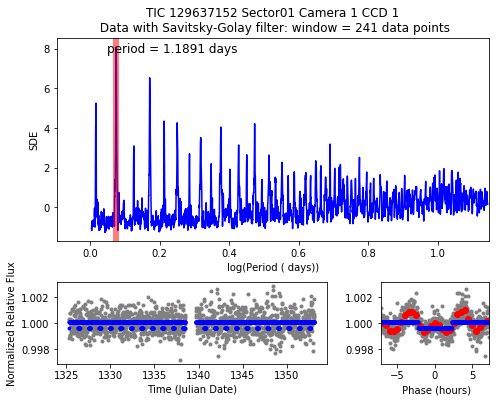

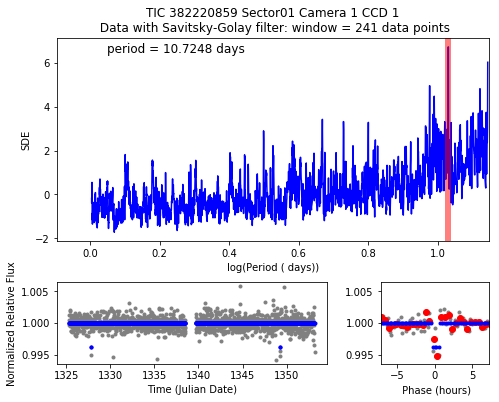

In [96]:
SDE_threshold = 6.5

for ii in range(len(data)): #for full data set

    d = np.loadtxt(data[ii])  #load in data

    t = np.transpose(d)[0] #time
    mm = np.transpose(d)[1] #magnitude
    mme = np.transpose(d)[2] #magnitude error

    #  to convert from magnitude to flux, you can use the following approximation:
#     y = 10.0**(mm/-2.5) #flux
    # let's normalize our flux by dividing by its average
    y = 10.0**(mm/-2.5)/np.mean(10.0**(mm/-2.5)) #now it should be centered on 1

    # to convert magnitude errors to flux errors, you can use the following approximation:
    z = y*( 1- 10.0**(mme/-2.5) )


    ID = (os.path.basename(data[ii]).split)('_')[0]
    

    Sector = "S"+(os.path.basename(data[ii]).split)('_')[1][1:] #by default, this has lower case "s"
    #^^^ so I added a capital "S" and remove the first element ("s") of this string
    # with this index slice [1:]. This isn't really imporant, just being tidy.

    Camera = (os.path.basename(data[ii]).split)('_')[2] 
    CCD = (os.path.basename(data[ii]).split)('_')[3][-4]
    
    #smoothing and outlier rejection
    newtime,newflux,newflux_error,window_size = SmoothAndRemove(t,y,z,10)
    
    #BLS
    minP=1.01 #maxP is length of light curve ~27 days (see BLS function)
    minDur = 1.0/24.0
    maxDur = 5.0/24.0
    
    bls, bls_power, bls_SDE, BLS_periods, BLS_t0s, BLS_depths, bls_model = BLS(newtime,newflux,newflux_error,ID,minP,minDur,maxDur,window_size,7.0)
    
    if np.max(bls_SDE) > SDE_threshold:
        PlotBLSResults(bls_power.period, bls_SDE,BLS_periods,ID,Sector,Camera,CCD,window_size, newtime,newflux,newflux_error, bls_model, BLS_t0s)
        
        
#     else: 
#         print("TIC "+ID+", weak peaks") #in case you want to see which targets fail our SDE quality check
    

TIC 91395551
Transit Least Squares TLS 1.0.23 (12 March 2019)
Creating model cache for 25 durations
Searching 1271 data points, 1726 periods from 1.01 to 9.278 days
Using all 4 CPU threads
 
TIC 114919247
Transit Least Squares TLS 1.0.23 (12 March 2019)
Creating model cache for 25 durations
Searching 1274 data points, 1726 periods from 1.01 to 9.278 days
Using all 4 CPU threads


/Users/felizd/anaconda/envs/py3.6/lib/python3.6/site-packages/transitleastsquares/stats.py:456: RuntimeWarning: divide by zero encountered in double_scalars
  snr_pink_per_transit[i] = (1 - mean_flux) / pinknoise


 
TIC 114985772
Transit Least Squares TLS 1.0.23 (12 March 2019)
Creating model cache for 25 durations
Searching 1276 data points, 1726 periods from 1.01 to 9.278 days
Using all 4 CPU threads
 
TIC 115175750
Transit Least Squares TLS 1.0.23 (12 March 2019)
Creating model cache for 25 durations
Searching 1272 data points, 1724 periods from 1.011 to 9.271 days
Using all 4 CPU threads
 
TIC 126583789
Transit Least Squares TLS 1.0.23 (12 March 2019)
Creating model cache for 25 durations
Searching 1272 data points, 1726 periods from 1.01 to 9.278 days
Using all 4 CPU threads


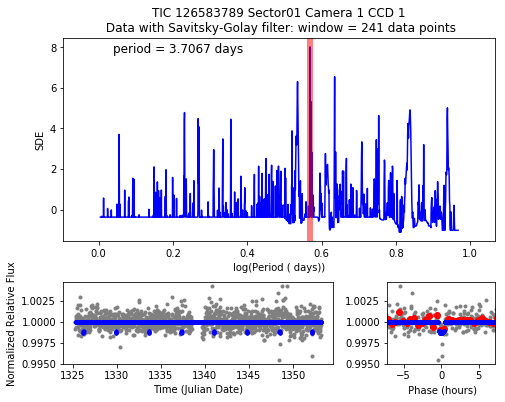

 
TIC 126909993
Transit Least Squares TLS 1.0.23 (12 March 2019)
Creating model cache for 25 durations
Searching 1270 data points, 1726 periods from 1.01 to 9.278 days
Using all 4 CPU threads


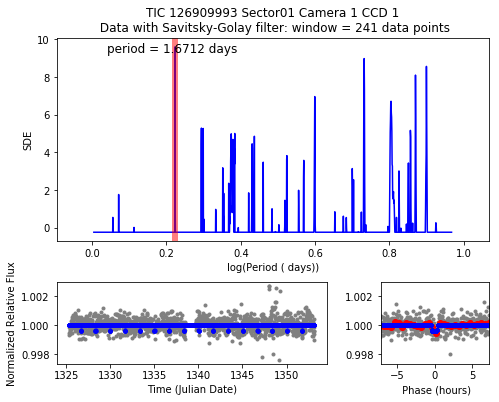

 
TIC 126910743
Transit Least Squares TLS 1.0.23 (12 March 2019)
Creating model cache for 25 durations
Searching 1268 data points, 1726 periods from 1.01 to 9.278 days
Using all 4 CPU threads


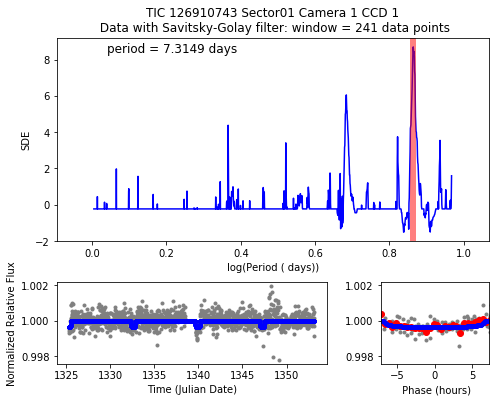

 
TIC 129637152
Transit Least Squares TLS 1.0.23 (12 March 2019)
Creating model cache for 25 durations
Searching 1274 data points, 1722 periods from 1.011 to 9.264 days
Using all 4 CPU threads


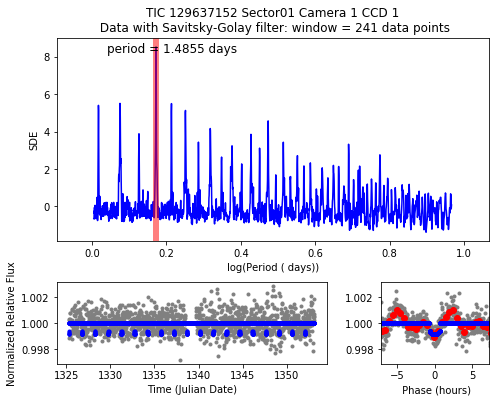

 
TIC 129683871
Transit Least Squares TLS 1.0.23 (12 March 2019)
Creating model cache for 25 durations
Searching 1276 data points, 1726 periods from 1.01 to 9.278 days
Using all 4 CPU threads
 
TIC 147113993
Transit Least Squares TLS 1.0.23 (12 March 2019)
Creating model cache for 25 durations
Searching 1270 data points, 1726 periods from 1.01 to 9.278 days
Using all 4 CPU threads
 
TIC 147114607
Transit Least Squares TLS 1.0.23 (12 March 2019)
Creating model cache for 25 durations
Searching 1271 data points, 1726 periods from 1.01 to 9.278 days
Using all 4 CPU threads


/Users/felizd/anaconda/envs/py3.6/lib/python3.6/site-packages/transitleastsquares/main.py:404: UserWarning: 1 of 3 transits without data. The true period may be twice the given period.
  warnings.warn(text)


 
TIC 147132816
Transit Least Squares TLS 1.0.23 (12 March 2019)
Creating model cache for 25 durations
Searching 1264 data points, 1726 periods from 1.01 to 9.278 days
Using all 4 CPU threads
 
TIC 147304087
Transit Least Squares TLS 1.0.23 (12 March 2019)
Creating model cache for 25 durations
Searching 1269 data points, 1726 periods from 1.01 to 9.278 days
Using all 4 CPU threads
 
TIC 147332553
Transit Least Squares TLS 1.0.23 (12 March 2019)
Creating model cache for 25 durations
Searching 1269 data points, 1726 periods from 1.01 to 9.278 days
Using all 4 CPU threads
 
TIC 165096120
Transit Least Squares TLS 1.0.23 (12 March 2019)
Creating model cache for 25 durations
Searching 1269 data points, 1726 periods from 1.01 to 9.278 days
Using all 4 CPU threads
 
TIC 165096625
Transit Least Squares TLS 1.0.23 (12 March 2019)
Creating model cache for 25 durations
Searching 1268 data points, 1724 periods from 1.011 to 9.271 days
Using all 4 CPU threads
 
TIC 165122191
Transit Least Squares T

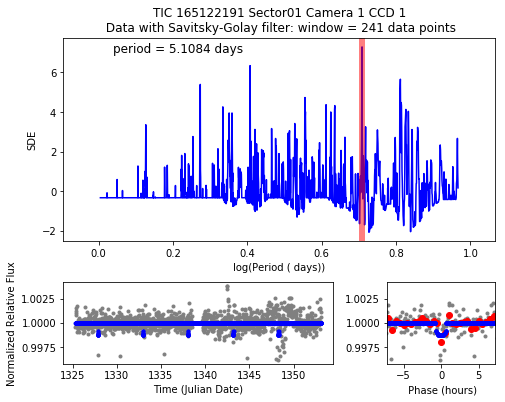

 
TIC 197598527
Transit Least Squares TLS 1.0.23 (12 March 2019)
Creating model cache for 25 durations
Searching 1270 data points, 1726 periods from 1.01 to 9.278 days
Using all 4 CPU threads
 
TIC 197598732
Transit Least Squares TLS 1.0.23 (12 March 2019)
Creating model cache for 25 durations
Searching 1271 data points, 1721 periods from 1.01 to 9.257 days
Using all 4 CPU threads
 
TIC 200644837
Transit Least Squares TLS 1.0.23 (12 March 2019)
Creating model cache for 25 durations
Searching 1275 data points, 1726 periods from 1.01 to 9.278 days
Using all 4 CPU threads


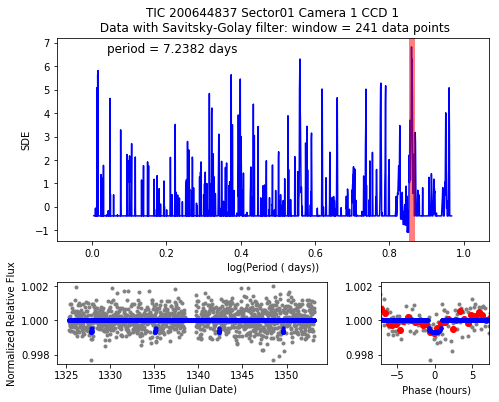

 
TIC 207080123
Transit Least Squares TLS 1.0.23 (12 March 2019)
Creating model cache for 25 durations
Searching 1276 data points, 1726 periods from 1.01 to 9.278 days
Using all 4 CPU threads
 
TIC 382220859
Transit Least Squares TLS 1.0.23 (12 March 2019)
Creating model cache for 25 durations
Searching 1278 data points, 1726 periods from 1.01 to 9.278 days
Using all 4 CPU threads
 
TIC 389448805
Transit Least Squares TLS 1.0.23 (12 March 2019)
Creating model cache for 25 durations
Searching 1277 data points, 1726 periods from 1.01 to 9.278 days
Using all 4 CPU threads
 
TIC 389657088
Transit Least Squares TLS 1.0.23 (12 March 2019)
Creating model cache for 25 durations
Searching 1271 data points, 1726 periods from 1.01 to 9.278 days
Using all 4 CPU threads
 


In [97]:
SDE_threshold = 6.5

for ii in range(len(data)): #for full data set

    d = np.loadtxt(data[ii])  #load in data

    t = np.transpose(d)[0] #time
    mm = np.transpose(d)[1] #magnitude
    mme = np.transpose(d)[2] #magnitude error

    #  to convert from magnitude to flux, you can use the following approximation:
#     y = 10.0**(mm/-2.5) #flux
    # let's normalize our flux by dividing by its average
    y = 10.0**(mm/-2.5)/np.mean(10.0**(mm/-2.5)) #now it should be centered on 1

    # to convert magnitude errors to flux errors, you can use the following approximation:
    z = y*( 1- 10.0**(mme/-2.5) )


    ID = (os.path.basename(data[ii]).split)('_')[0]
    print("TIC "+ID)

    Sector = "S"+(os.path.basename(data[ii]).split)('_')[1][1:] #by default, this has lower case "s"
    #^^^ so I added a capital "S" and remove the first element ("s") of this string
    # with this index slice [1:]. This isn't really imporant, just being tidy.

    Camera = (os.path.basename(data[ii]).split)('_')[2] 
    CCD = (os.path.basename(data[ii]).split)('_')[3][-4]
    
    #smoothing and outlier rejection
    newtime,newflux,newflux_error,window_size = SmoothAndRemove(t,y,z,10)
    
    #TLS
    minP=1.01 #maxP is length of light curve ~27 days (see BLS function)
    
    tls, tls_power, TLS_SDE, TLS_periods, TLS_depths, TLS_t0s,TLS_model_time,TLS_model = TLS(newtime,newflux,newflux_error,minP,window_size)
    
    if np.max(TLS_SDE) > SDE_threshold:
        PlotTLSResults(newtime, newflux, newflux_error, TLS_periods,TLS_t0s,tls_power.periods,TLS_SDE, ID, Sector, Camera, CCD, window_size,TLS_model_time,TLS_model)
        
    print(" ")
#     else: 
#         print("TIC "+ID+", weak peaks") #in case you want to see which targets fail our SDE quality check
    

In [98]:
%reset -s -f #useful if you want to reset all your saved variables

Don't know how to reset  #useful, please run `%reset?` for details
Don't know how to reset  if, please run `%reset?` for details
Don't know how to reset  you, please run `%reset?` for details
Don't know how to reset  want, please run `%reset?` for details
Don't know how to reset  to, please run `%reset?` for details
Don't know how to reset  reset, please run `%reset?` for details
Don't know how to reset  all, please run `%reset?` for details
Don't know how to reset  your, please run `%reset?` for details
Don't know how to reset  saved, please run `%reset?` for details
Don't know how to reset  variables, please run `%reset?` for details
